In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from scipy.stats import norm 
import math
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce 
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import svm, datasets


In [2]:
df = pd.read_csv('post_eda.csv',index_col='id',usecols=['id','gender','age','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi','smoking_status','stroke'])

In [3]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


During EDA, residence type and gender came back with no statistical signficance, I don't feel comfortable assuming that gender is not a significant factor when it comes to stroke risk, so I will only focus on what happens if I were to remove the Residence_type column. I want to keep both dataframes to see the difference in results further down the line. 

In [4]:
df_nores = df.drop(columns='Residence_type')
df_nores.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,228.69,36.600000,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,202.21,28.893237,never smoked,1
31112,Male,80.0,0,1,Yes,Private,105.92,32.500000,never smoked,1
60182,Female,49.0,0,0,Yes,Private,171.23,34.400000,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,174.12,24.000000,never smoked,1


# Creating indicator variables for categorical columns using Binary Encoder

* Went with Binary Encoder over Ordinal Encoding here since my data does not necesarily comprised of ordered variables. Binary encoding keeps the dimensionality down (vs. One Hot Encoding) and saves on memory. 

In [5]:
encoder = ce.BinaryEncoder(cols=['gender','ever_married','work_type','Residence_type','smoking_status'],return_df=True,drop_invariant=False)
encoded_df = encoder.fit_transform(df)
encoded_df.head()

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,gender_0,gender_1,gender_2,age,hypertension,heart_disease,ever_married_0,ever_married_1,work_type_0,work_type_1,work_type_2,work_type_3,Residence_type_0,Residence_type_1,avg_glucose_level,bmi,smoking_status_0,smoking_status_1,smoking_status_2,stroke
id,,,,,,,,,,,,,,,,,,,,
9046,0,0,1,67.0,0,1,0,1,0,0,0,1,0,1,228.69,36.600000,0,0,1,1
51676,0,1,0,61.0,0,0,0,1,0,0,1,0,1,0,202.21,28.893237,0,1,0,1
31112,0,0,1,80.0,0,1,0,1,0,0,0,1,1,0,105.92,32.500000,0,1,0,1
60182,0,1,0,49.0,0,0,0,1,0,0,0,1,0,1,171.23,34.400000,0,1,1,1
1665,0,1,0,79.0,1,0,0,1,0,0,1,0,1,0,174.12,24.000000,0,1,0,1


In [6]:
encoder = ce.BinaryEncoder(cols=['gender','ever_married','work_type','smoking_status'],return_df=True)
encoded_df_nores = encoder.fit_transform(df_nores)
encoded_df_nores.head()

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,gender_0,gender_1,gender_2,age,hypertension,heart_disease,ever_married_0,ever_married_1,work_type_0,work_type_1,work_type_2,work_type_3,avg_glucose_level,bmi,smoking_status_0,smoking_status_1,smoking_status_2,stroke
id,,,,,,,,,,,,,,,,,,
9046,0,0,1,67.0,0,1,0,1,0,0,0,1,228.69,36.600000,0,0,1,1
51676,0,1,0,61.0,0,0,0,1,0,0,1,0,202.21,28.893237,0,1,0,1
31112,0,0,1,80.0,0,1,0,1,0,0,0,1,105.92,32.500000,0,1,0,1
60182,0,1,0,49.0,0,0,0,1,0,0,0,1,171.23,34.400000,0,1,1,1
1665,0,1,0,79.0,1,0,0,1,0,0,1,0,174.12,24.000000,0,1,0,1


# Train Test split 

In [7]:
# SMOTE for imbalanced data with residence feature
X = encoded_df.drop(columns='stroke')
y = encoded_df['stroke']

from imblearn.over_sampling import SMOTE 
smote = SMOTE()
x_smote,y_smote = smote.fit_resample(X,y)

In [8]:
# df with Residence Type 
X_train,X_test,y_train,y_test = train_test_split(x_smote,y_smote,test_size=0.3,random_state=10)

In [9]:
# SMOTE for imbalanced data without residence feature 
Xnores = encoded_df_nores.drop(columns = 'stroke')
ynores = encoded_df_nores['stroke']

from imblearn.over_sampling import SMOTE 
smote = SMOTE()
x_smotenores,y_smotenores = smote.fit_resample(Xnores,ynores)

In [10]:
# df without Residence Type 
X_trainnores,X_testnores,y_trainnores,y_testnores = train_test_split(x_smotenores,y_smotenores,test_size=0.3,random_state=12)

# Normalizing numerical features
* EDA showed all numerical features were not normally distributed

In [11]:
encoded_df.dtypes

gender_0               int64
gender_1               int64
gender_2               int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married_0         int64
ever_married_1         int64
work_type_0            int64
work_type_1            int64
work_type_2            int64
work_type_3            int64
Residence_type_0       int64
Residence_type_1       int64
avg_glucose_level    float64
bmi                  float64
smoking_status_0       int64
smoking_status_1       int64
smoking_status_2       int64
stroke                 int64
dtype: object

In [12]:
scaler = MinMaxScaler()

In [13]:
X_train
cols_to_norm = ['age','avg_glucose_level','bmi']
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])
X_train

<ipython-input-13-55bb4c99b833>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,gender_0,gender_1,gender_2,age,hypertension,heart_disease,ever_married_0,ever_married_1,work_type_0,work_type_1,work_type_2,work_type_3,Residence_type_0,Residence_type_1,avg_glucose_level,bmi,smoking_status_0,smoking_status_1,smoking_status_2
4421,0,1,0,0.218750,0,0,1,0,0,0,0,1,0,1,0.203712,0.174112,0,0,1
4955,0,0,1,0.462891,0,0,0,1,0,0,0,1,0,1,0.745274,0.324170,0,0,1
1758,0,0,1,0.020020,0,0,1,0,0,1,0,0,0,1,0.164028,0.139748,1,0,0
57,0,0,1,0.951172,0,0,0,1,0,0,0,1,0,1,0.847664,0.212981,0,0,1
5276,0,0,0,0.975586,0,1,0,1,0,0,0,0,0,0,0.057579,0.143328,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9372,0,1,0,0.975586,0,0,0,1,0,0,0,0,0,1,0.058458,0.363771,0,1,0
7291,0,0,1,0.755219,0,0,0,1,0,0,0,1,0,0,0.716421,0.228231,0,0,0
1344,0,0,1,0.572754,0,0,0,1,0,0,0,1,1,0,0.145045,0.331042,0,1,1
7293,0,1,0,0.589103,0,0,0,1,0,0,1,0,0,0,0.218392,0.200572,0,0,1


In [14]:
X_test
cols_to_norm = ['age','avg_glucose_level','bmi']
X_test[cols_to_norm] = scaler.fit_transform(X_test[cols_to_norm])
X_test

<ipython-input-14-3948e12609fe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[cols_to_norm] = scaler.fit_transform(X_test[cols_to_norm])
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,gender_0,gender_1,gender_2,age,hypertension,heart_disease,ever_married_0,ever_married_1,work_type_0,work_type_1,work_type_2,work_type_3,Residence_type_0,Residence_type_1,avg_glucose_level,bmi,smoking_status_0,smoking_status_1,smoking_status_2
2167,0,0,1,0.487305,0,0,0,1,0,0,0,1,1,0,0.115397,0.282707,0,0,1
9191,0,1,0,0.839632,0,0,0,0,0,0,1,0,0,1,0.125307,0.251632,0,1,0
2790,0,0,1,0.121094,0,0,1,0,0,1,0,0,1,0,0.063150,0.097744,1,0,0
1733,0,1,0,0.548340,0,0,0,1,0,0,0,1,1,0,0.101261,0.386466,0,1,1
2318,0,1,0,0.621582,1,0,0,1,0,0,0,1,0,1,0.548298,0.296241,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5900,0,0,0,0.950254,0,0,0,1,0,0,0,0,0,0,0.542093,0.203793,0,0,0
5371,0,0,0,0.969551,0,0,0,1,0,0,0,1,0,0,0.089527,0.187598,0,0,0
2249,0,1,0,0.108887,0,0,1,0,0,1,0,0,1,0,0.322539,0.058647,1,0,0
2923,0,1,0,0.499512,0,0,0,1,0,0,0,1,0,1,0.072943,0.178947,0,1,0


In [15]:
cols_to_norm = ['age','avg_glucose_level','bmi']
X_trainnores[cols_to_norm] = scaler.fit_transform(X_trainnores[cols_to_norm])
X_trainnores

<ipython-input-15-ab1879bc8973>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_trainnores[cols_to_norm] = scaler.fit_transform(X_trainnores[cols_to_norm])
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,gender_0,gender_1,gender_2,age,hypertension,heart_disease,ever_married_0,ever_married_1,work_type_0,work_type_1,work_type_2,work_type_3,avg_glucose_level,bmi,smoking_status_0,smoking_status_1,smoking_status_2
7857,0,0,0,0.943897,0,0,0,1,0,0,1,0,0.166857,0.223516,0,0,0
8274,0,1,0,0.975586,0,0,0,1,0,0,1,0,0.061242,0.165795,0,0,0
3716,0,1,0,0.841309,0,0,1,0,0,0,0,1,0.019343,0.231127,0,1,1
9035,0,1,0,0.702607,0,0,0,1,0,0,0,1,0.034514,0.212264,0,0,0
3653,0,1,0,0.169922,0,0,1,0,0,0,0,1,0.294340,0.220674,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3714,0,1,0,0.017090,0,0,1,0,0,1,0,0,0.029591,0.104530,1,0,0
7409,0,0,1,0.999546,0,0,0,1,0,0,0,1,0.414526,0.173084,0,0,1
3325,0,1,0,0.414062,0,0,0,1,0,0,0,1,0.265072,0.138211,0,0,1
9606,0,0,0,0.868470,0,0,0,0,0,0,0,1,0.750108,0.220075,0,0,0


In [16]:
cols_to_norm = ['age','avg_glucose_level','bmi']
X_testnores[cols_to_norm] = scaler.fit_transform(X_testnores[cols_to_norm])
X_testnores

<ipython-input-16-932c2eb41028>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_testnores[cols_to_norm] = scaler.fit_transform(X_testnores[cols_to_norm])
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,gender_0,gender_1,gender_2,age,hypertension,heart_disease,ever_married_0,ever_married_1,work_type_0,work_type_1,work_type_2,work_type_3,avg_glucose_level,bmi,smoking_status_0,smoking_status_1,smoking_status_2
4954,0,1,0,0.987793,0,0,1,0,0,0,1,0,0.010209,0.429358,0,1,0
7659,0,0,0,0.890549,0,0,0,1,0,0,0,1,0.827778,0.450937,0,0,1
9133,0,0,1,0.979604,0,0,0,1,0,0,0,1,0.947958,0.370917,0,1,1
9378,0,0,0,0.705427,0,0,0,1,0,0,0,1,0.631726,0.355036,0,0,0
4698,0,1,0,0.523926,0,0,0,1,0,0,1,0,0.057629,0.185321,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5596,0,0,1,0.932026,0,0,0,1,0,0,0,0,0.393791,0.374283,0,0,0
1837,0,1,0,0.731445,0,0,0,1,0,0,1,0,0.695268,0.341160,0,1,1
3043,0,1,0,0.450684,0,0,0,1,0,0,0,1,0.215557,0.295413,1,0,0
3186,0,1,0,0.829102,0,0,0,1,0,0,1,1,0.753086,0.306422,0,0,1


# Random Forest Model
* Want to try a Random Forest model first.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [18]:
modelRF = RandomForestClassifier()

In [19]:
n_estimators=[500,800,1500,2500,5000]
max_features = ['auto','sqrt','log2']
max_depth = [10,20,30,40,50]
max_depth.append(None)
min_samples_split = [2,5,10,15,20]
min_samples_leaf = [1,2,5,10,15]
grid_param = {'n_estimators':n_estimators,'max_features':max_features,'max_depth':max_depth,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf}


In [87]:
RF_random = RandomizedSearchCV(estimator=modelRF,param_distributions = grid_param,n_iter=500,cv=5,verbose=2,random_state=111,n_jobs=-1)
RF_random.fit(X_train,y_train)
RF_random.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


{'n_estimators': 2500,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 30}

In [20]:
RF_model = RandomForestClassifier(n_estimators=2500,min_samples_split=5,min_samples_leaf=1,max_features='auto',max_depth=30)

In [21]:
RF_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=2500)

In [22]:
rf_predict = RF_model.predict(X_test)

In [23]:
rf_probs = RF_model.predict_proba(X_test)[:,1]

In [24]:
roc_value = roc_auc_score(y_test,rf_probs)
roc_value

0.9916279179106231

In [25]:
tn,fp,fn,tp = confusion_matrix(y_test,rf_predict).ravel()
print(tn,fp,fn,tp)

1449 26 80 1362


[[1449   26]
 [  80 1362]]


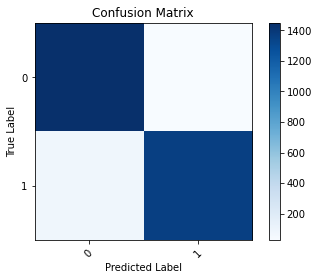

In [26]:
target_names = [0,1]
cm = confusion_matrix(y_test,rf_predict)

def plot_confusion_matrix(cm,classes,title='Confusion matrix',cmap=plt.cm.Blues):
    print(cm)
    
    plt.imshow(cm, interpolation = 'nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout
    
plt.figure()
plot_confusion_matrix(cm,classes=target_names,title='Confusion Matrix')
plt.show()

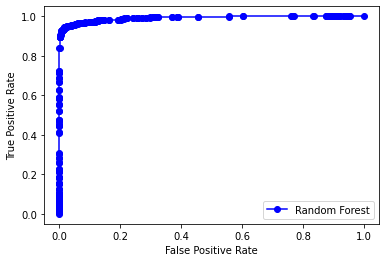

In [27]:
fpr,tpr,_ = roc_curve(y_test,rf_probs)

plt.plot(fpr,tpr,marker='o',color='blue',label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Random Forest Model for data that doesn't include Residence Type

In [ ]:
RF_random = RandomizedSearchCV(estimator=modelRF,param_distributions = grid_param,n_iter=500,cv=5,verbose=2,random_state=111,n_jobs=-1)
RF_random.fit(X_trainnores,y_trainnores)
RF_random.best_params_

* Ran the above cell to get the following hyperparameters that are used for this model. Will not be re-running so that time will be saved. 

In [29]:
RF_model = RandomForestClassifier(n_estimators=5000,min_samples_split=2,min_samples_leaf=1,max_features='auto',max_depth=30)

In [30]:
RF_model.fit(X_trainnores,y_trainnores)

RandomForestClassifier(max_depth=30, n_estimators=5000)

In [31]:
rf_predictnores = RF_model.predict(X_testnores)

In [32]:
rf_probsnores = RF_model.predict_proba(X_testnores)[:,1]

In [33]:
roc_value = roc_auc_score(y_testnores,rf_probsnores)
roc_value

0.9863823785232375

In [34]:
tn,fp,fn,tp = confusion_matrix(y_testnores,rf_predictnores).ravel()
print(tn,fp,fn,tp)

1416 26 168 1307


* Reducing dimensionality slightly decreased the roc_auc_score but increased the rate of false negatives by quite a bit. Due to the nature of our problem statement, I don't think it is worth it to risk having more false negatives reported. 

* Running the Random Forest Model with the Residence Type feature included gave decent results for what we are trying to solve. Going to try a few other models to make sure this is the best choice.

# Logistic Regression Model

* The predicted outcome for this model needs to be binary -- stroke negative(0) or stroke positive(1) so I want to start looking into models that support that. First I'll try logistic regression where I'll be predicting the probability of a particular outcome rather than the outcome itself.  

In [35]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score

In [45]:
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(class_weight='balanced')
Cs = {'C':[0.001,0.1,1,10,100]}
model = GridSearchCV(clf,Cs,cv=5,scoring='accuracy')
model.fit(X_train,y_train)
model.best_estimator_,model.best_score_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

(LogisticRegression(C=10, class_weight='balanced'), 0.9384276267450404)

In [46]:
clf = LogisticRegression(C=10)

In [47]:
clf.fit(X_train,y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

In [48]:
y_predlr = clf.predict(X_test)

In [49]:
print('R-squared value:',clf.score(X_train,y_train))

R-squared value: 0.9391623806024981


In [50]:
accscore = accuracy_score(y_predlr,y_test)
print('Accuracy score:',accscore)

Accuracy score: 0.9352074048680151


In [51]:
roc_score = roc_auc_score(y_test,y_predlr)
roc_score

0.9348926867110182

In [52]:
f1_score(y_test,y_predlr)

0.932620320855615

In [53]:
from sklearn.metrics import confusion_matrix

tn,fp,fn,tp = confusion_matrix(y_test,y_predlr).ravel()
print(tn,fp,fn,tp)

1420 55 134 1308


[[1420   55]
 [ 134 1308]]


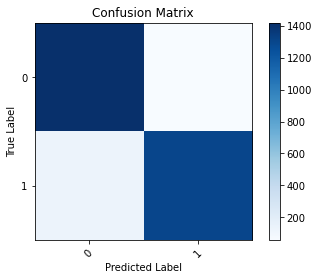

In [54]:
target_names = [0,1]
cm = confusion_matrix(y_test,y_predlr)

def plot_confusion_matrix(cm,classes,title='Confusion matrix',cmap=plt.cm.Blues):
    print(cm)
    
    plt.imshow(cm, interpolation = 'nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout
    
plt.figure()
plot_confusion_matrix(cm,classes=target_names,title='Confusion Matrix')
plt.show()

The scores we're getting from this model are decent but I'm still choosing to focus on the confusion matrix output. The Random Forest Model was performing better in terms of the false positve and false negative values. 

### Logistic Regression for data that does not include Residence Type 

In [56]:
from sklearn.model_selection import GridSearchCV

clf_nores = LogisticRegression(class_weight='balanced')
Cs = {'C':[0.001,0.1,1,10,100]}
model = GridSearchCV(clf_nores,Cs,cv=5,scoring='accuracy')
model.fit(X_trainnores,y_trainnores)
model.best_estimator_,model.best_score_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

(LogisticRegression(C=100, class_weight='balanced'), 0.9012490815576782)

In [57]:
clf_nores = LogisticRegression(class_weight='balanced',C=100)

clf_nores.fit(X_trainnores,y_trainnores)
y_pred_nores = clf_nores.predict(X_testnores)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [58]:
print('R-squared value:',clf_nores.score(X_trainnores,y_trainnores))

R-squared value: 0.9025716385011021


In [59]:
accscore = accuracy_score(y_pred_nores,y_testnores)
print('Accuracy score:',accscore)

Accuracy score: 0.910867329448063


In [60]:
roc_score = roc_auc_score(y_testnores,y_pred_nores)
roc_score

0.9108636780366252

In [61]:
f1_score(y_testnores,y_pred_nores)

0.9118046132971506

In [62]:
from sklearn.metrics import confusion_matrix

tn,fp,fn,tp = confusion_matrix(y_testnores,y_pred_nores).ravel()
print(tn,fp,fn,tp)

1313 129 131 1344


[[1313  129]
 [ 131 1344]]


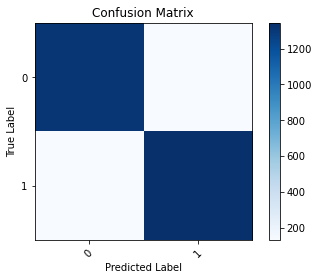

In [63]:
target_names = [0,1]
cm = confusion_matrix(y_testnores,y_pred_nores)

def plot_confusion_matrix(cm,classes,title='Confusion matrix',cmap=plt.cm.Blues):
    print(cm)
    
    plt.imshow(cm, interpolation = 'nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout
    
plt.figure()
plot_confusion_matrix(cm,classes=target_names,title='Confusion Matrix')
plt.show()

* Decreasing dimensionality by removing the Residence Type feature ended up decreasing the accuracy of the model. The values we're getting from the confusion matrix are also not impressing me. In the case of needing to tell a patient whether they're at risk for stroke, it is more important to have fewer false negatives (want to make sure all patient's are getting the care they need). False positives are also something I'm looking for here since having too much false positives could become an issue financially. 

# Naive Bayes Model 
* I want to try out the different types of Naive Bayes models as well since the data is fairly simple and I like that it will rank my predictions by probability. 

In [64]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

### Gaussian Naive Bayes

In [65]:
model = GaussianNB()
model.fit(X_train,y_train)
y_predg = model.predict(X_test)

In [66]:
print('Gaussian Accuracy score:',accuracy_score(y_predg,y_test))

Gaussian Accuracy score: 0.7610558793280768


In [67]:
print('Gaussian f1 score:',f1_score(y_test,y_predg))

Gaussian f1 score: 0.7926212436774771


In [68]:
print('Gaussian ROC AUC Score:',roc_auc_score(y_test,y_predg))

Gaussian ROC AUC Score: 0.7628754789722373


In [69]:
tn,fp,fn,tp = confusion_matrix(y_test,y_predg).ravel()
print(tn,fp,fn,tp)

888 587 110 1332


### Bernoulli Naive Bayes

In [70]:
bnb = BernoulliNB(binarize=True)
bnb.fit(X_train,y_train)
y_predB = bnb.predict(X_test)
accuracy_score(y_predB,y_test)

0.4943435035995886

In [71]:
print('Bernoulli Accuracy score:',accuracy_score(y_predB,y_test))

Bernoulli Accuracy score: 0.4943435035995886


In [72]:
print('Bernoulli f1 score:',f1_score(y_test,y_predB))

Bernoulli f1 score: 0.661619637531544


In [73]:
print('Bernoulli ROC AUC Score:',roc_auc_score(y_test,y_predB))

Bernoulli ROC AUC Score: 0.5


* roc_auc_score is no better than if the model was predicting at random 

In [74]:
tn,fp,fn,tp = confusion_matrix(y_test,y_predB).ravel()
print(tn,fp,fn,tp)

0 1475 0 1442


### Multinomial Naive Bayes 

In [75]:
mnb = MultinomialNB()
y_predmnb = mnb.fit(X_train,y_train).predict(X_test)
accuracy_score(y_predmnb,y_test)

0.7206033596160438

In [76]:
print('Multinomial Accuracy score:',accuracy_score(y_predmnb,y_test))

Multinomial Accuracy score: 0.7206033596160438


In [77]:
print('Multinomial f1 score:',f1_score(y_test,y_predmnb))

Multinomial f1 score: 0.764518925166137


In [78]:
print('Multinomial ROC AUC Score:',roc_auc_score(y_test,y_predmnb))

Multinomial ROC AUC Score: 0.7228056606878395


In [79]:
tn,fp,fn,tp = confusion_matrix(y_test,y_predmnb).ravel()
print(tn,fp,fn,tp)

779 696 119 1323


# Summary

* Overall, all Naive Bayes models are not performing better than anything else we have tried; they're actually performing worse.  

* The model evaluation metrics I want to focus on are the false positive and false negative values to make sure all patients are getting the treatment they need (need fewer false negatives for this) and that we are taking into account the financial cost of treating patients who are not actually at risk (fewer false positives for this). 

* Overall, the Random Forest model seems to be the best option. Keeping the Residence Type feature also produces better results than if we were to remove it. 